In [1]:
# import all the necessary packages to implement transfer learning

In [2]:
import os
from tensorflow.keras import Model
from tensorflow.keras import layers



In [3]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
-O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2021-12-29 11:14:10--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  87.5MB/s    in 1.0s    

2021-12-29 11:14:11 (87.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pretrained_model = InceptionV3(input_shape = (150,150,3),
                               include_top = False,
                               weights = None)

weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model.load_weights(weights)

for layer in pretrained_model.layers: # freezing the early layers of the model
  layer.trainable = False




In [5]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
last_layer = pretrained_model.get_layer('mixed7')

In [6]:
print('last layer shape:', last_layer.output.shape)

last layer shape: (None, 7, 7, 768)


In [7]:
last_output = last_layer.output

In [8]:
# now stake the model to build the custom classification model using transfer learning
input = pretrained_model.input
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = input, outputs = output )

In [9]:
from tensorflow.keras.optimizers import RMSprop

# compile the model
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

file = zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r')
file.extractall('/tmp')
file.close()




Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 147MB/s] 


In [11]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')


validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')



print('number of cats images in the training directory:', len(os.listdir(train_cats_dir)))
print('number of dogs images in the training directory:', len(os.listdir(train_dogs_dir)))
print('number of cats images in the validation directory:', len(os.listdir(validation_cats_dir)))
print('number of dogs images in the validation directory:', len(os.listdir(validation_cats_dir)))



number of cats images in the training directory: 1000
number of dogs images in the training directory: 1000
number of cats images in the validation directory: 500
number of dogs images in the validation directory: 500


In [12]:
train_gen = ImageDataGenerator(rescale = 1/255, 
                               rotation_range = 40, 
                               width_shift_range= 0.2,
                               height_shift_range= 0.2,
                               shear_range= 0.2,
                               zoom_range= 0.2,
                               horizontal_flip= True,
                               fill_mode = 'nearest')

validation_gen = ImageDataGenerator(rescale = 1/255)

training_generator = train_gen.flow_from_directory(train_dir,
                                                   target_size = (150, 150),
                                                   batch_size = 20,
                                                   class_mode= 'binary')

validation_generator = validation_gen.flow_from_directory(validation_dir,
                                                          target_size = (150, 150),
                                                          batch_size = 20,
                                                          class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
#now, it's all set to train our model.

history = model.fit(training_generator,
                    validation_data= validation_generator,
                    epochs = 20,
                    steps_per_epoch = 100,
                    verbose = 2)

Epoch 1/20
100/100 - 44s - loss: 0.3562 - accuracy: 0.8645 - val_loss: 0.2543 - val_accuracy: 0.9060 - 44s/epoch - 440ms/step
Epoch 2/20
100/100 - 24s - loss: 0.2237 - accuracy: 0.9140 - val_loss: 0.1143 - val_accuracy: 0.9580 - 24s/epoch - 239ms/step
Epoch 3/20
100/100 - 24s - loss: 0.2155 - accuracy: 0.9190 - val_loss: 0.0995 - val_accuracy: 0.9680 - 24s/epoch - 243ms/step
Epoch 4/20
100/100 - 23s - loss: 0.2006 - accuracy: 0.9270 - val_loss: 0.1604 - val_accuracy: 0.9470 - 23s/epoch - 234ms/step
Epoch 5/20
100/100 - 22s - loss: 0.1799 - accuracy: 0.9290 - val_loss: 0.1099 - val_accuracy: 0.9640 - 22s/epoch - 220ms/step
Epoch 6/20
100/100 - 21s - loss: 0.1526 - accuracy: 0.9420 - val_loss: 0.2425 - val_accuracy: 0.9400 - 21s/epoch - 213ms/step
Epoch 7/20
100/100 - 22s - loss: 0.1837 - accuracy: 0.9430 - val_loss: 0.1272 - val_accuracy: 0.9580 - 22s/epoch - 216ms/step
Epoch 8/20
100/100 - 21s - loss: 0.1675 - accuracy: 0.9440 - val_loss: 0.1048 - val_accuracy: 0.9660 - 21s/epoch - 211

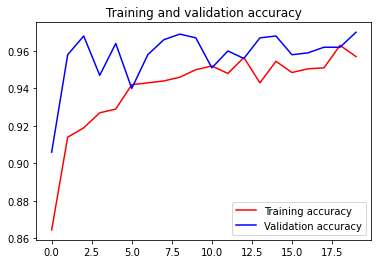

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()